In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/dell/miniconda3/envs/taming/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [3]:
config16384 = load_config("../logs/temp/configs/2023-05-11T15-53-47-project.yaml", display=False)
model16384 = load_vqgan(config16384, ckpt_path="../logs/temp/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from IPython.display import display, display_markdown
from dall_e          import map_pixels, unmap_pixels, load_model


font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle: 
      img = map_pixels(img)
    return img


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x0, titles=[]):
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (5*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

In [5]:
titles=["Input", "VQGAN (f16, 16384)"]

def reconstruction_pipeline(url, size=320):
  x_vqgan = preprocess(download_image(url), target_image_size=size, map_dalle=False)
  x_vqgan = x_vqgan.to(DEVICE)
  
  print(f"input is of size: {x_vqgan.shape}")
  x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model16384)
  img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x_vqgan[0])), custom_to_pil(x1[0]), titles=titles)
  return img

/home/dell/miniconda3/envs/taming/lib/python3.9/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])


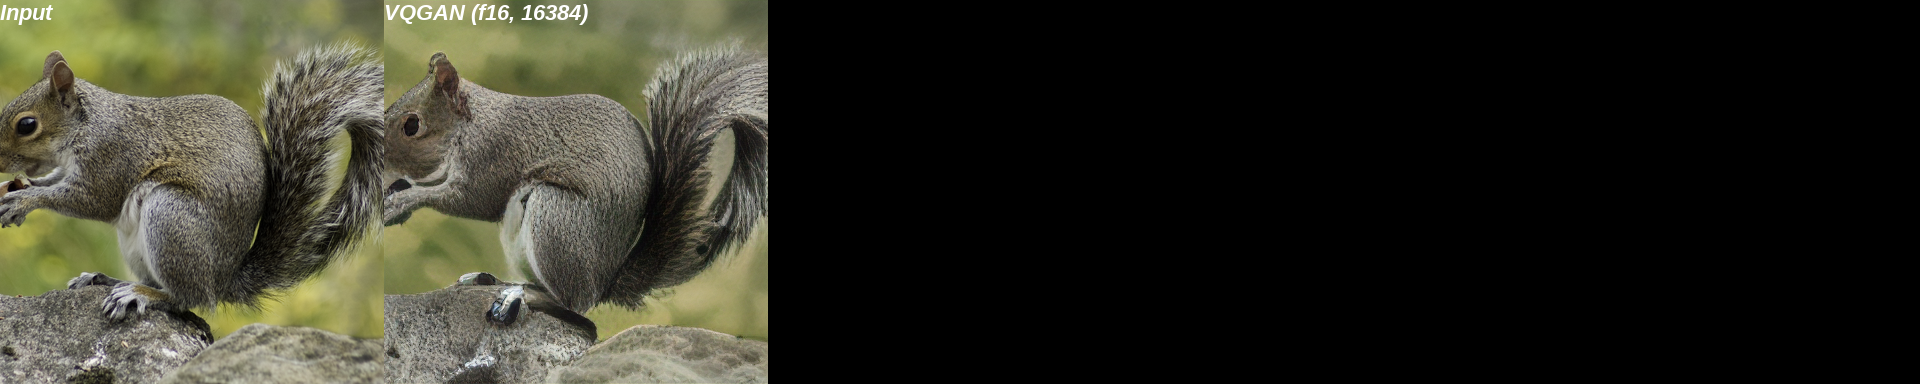

In [6]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1', size=384)

input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])


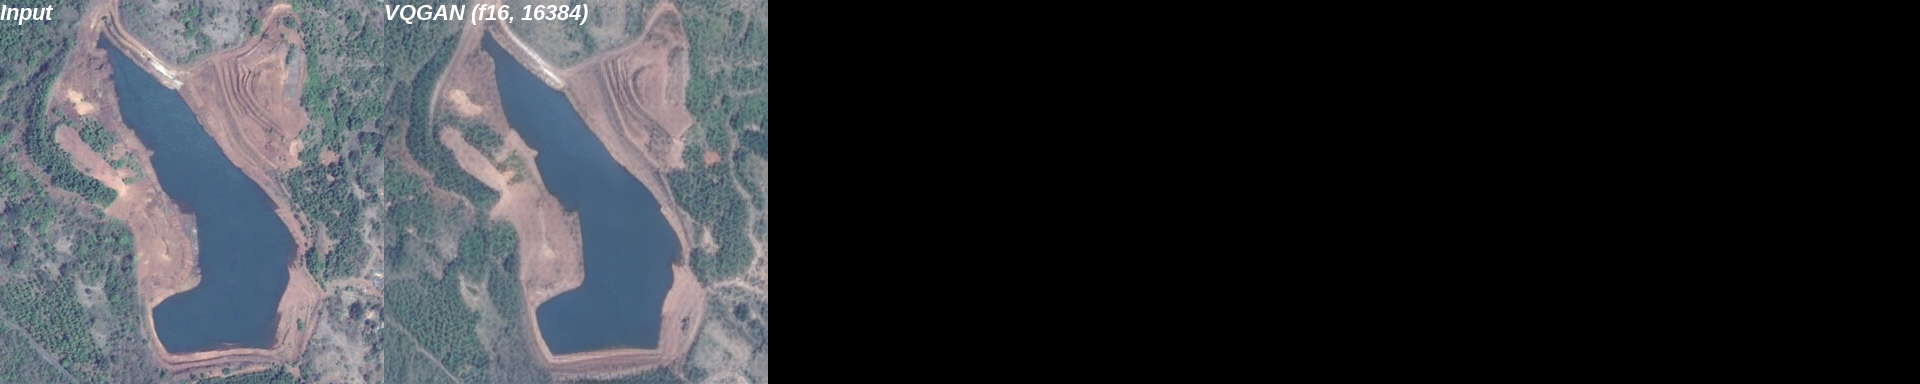

In [7]:
reconstruction_pipeline(url='https://www.hualigs.cn/image/645dd26aa1b5f.jpg', size=384)

input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])


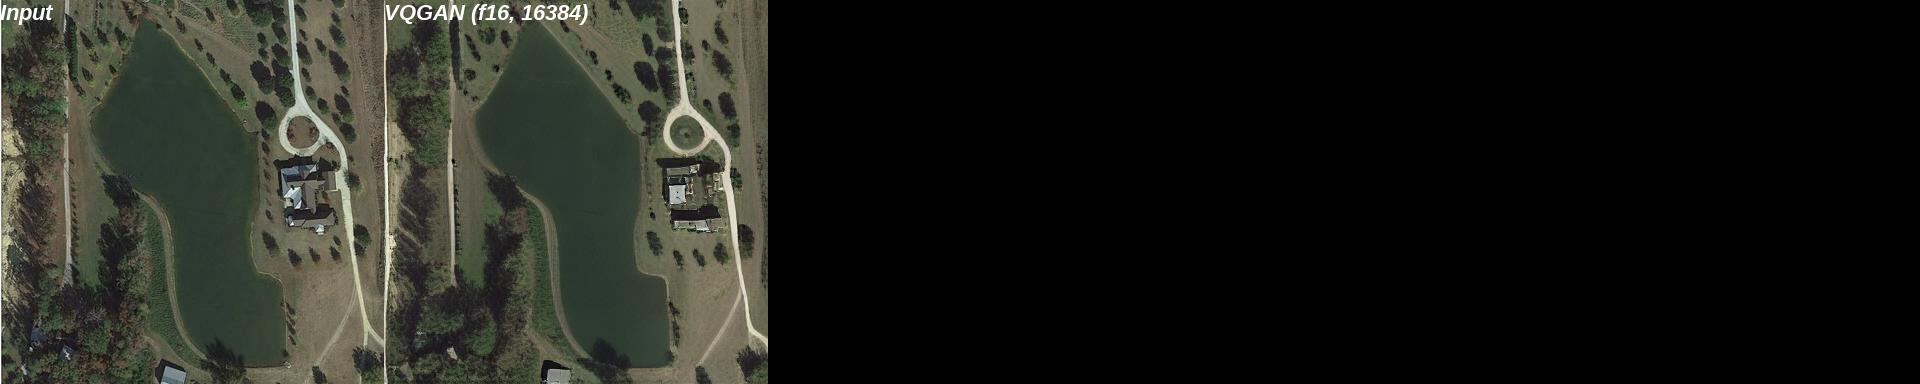

In [8]:
reconstruction_pipeline(url='https://www.hualigs.cn/image/645dd2e68b15b.jpg', size=384)

input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])


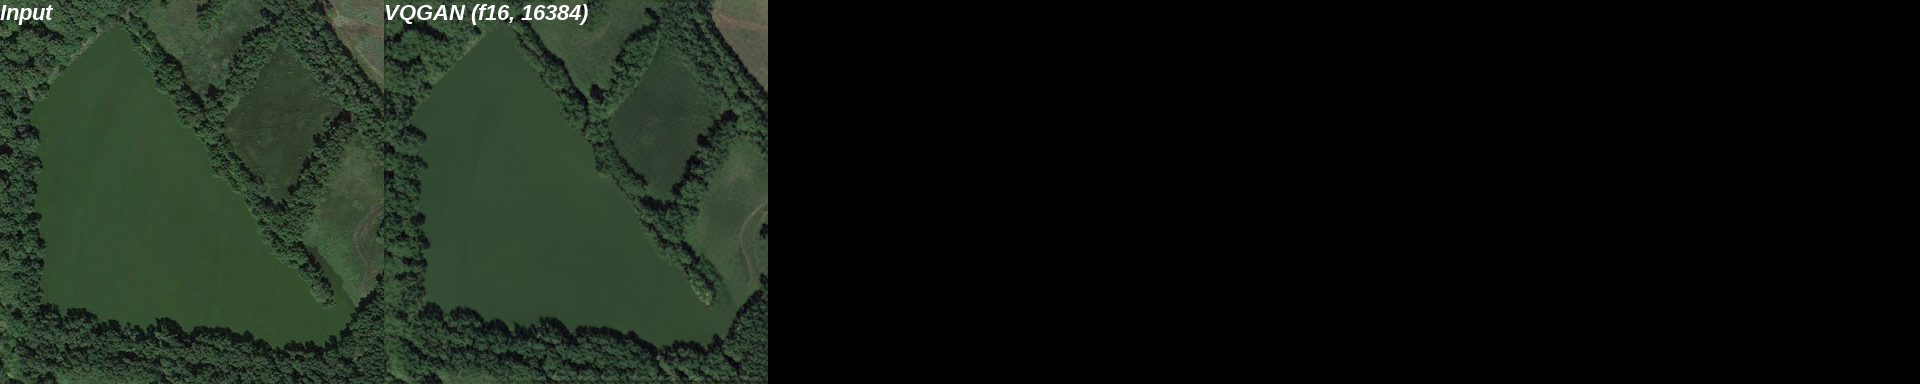

In [9]:
reconstruction_pipeline(url='https://www.hualigs.cn/image/645dd2f159d36.jpg', size=384)

input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])


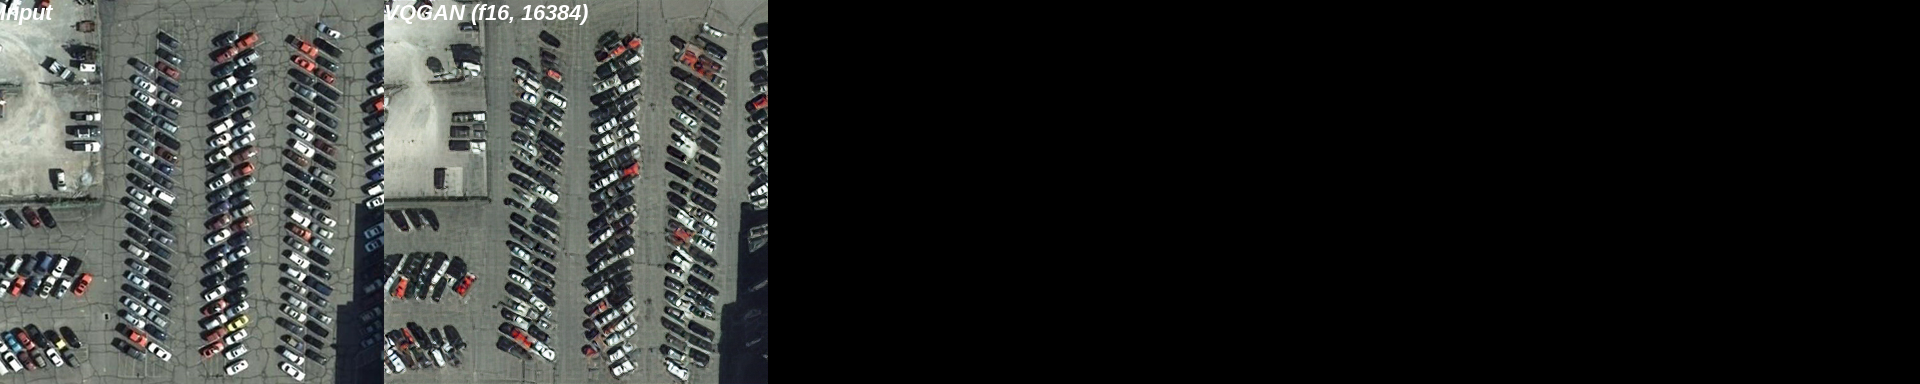

In [10]:
reconstruction_pipeline(url='https://www.hualigs.cn/image/645dd35367086.jpg', size=384)